# Face Recognition using MTCNN and FaceNet
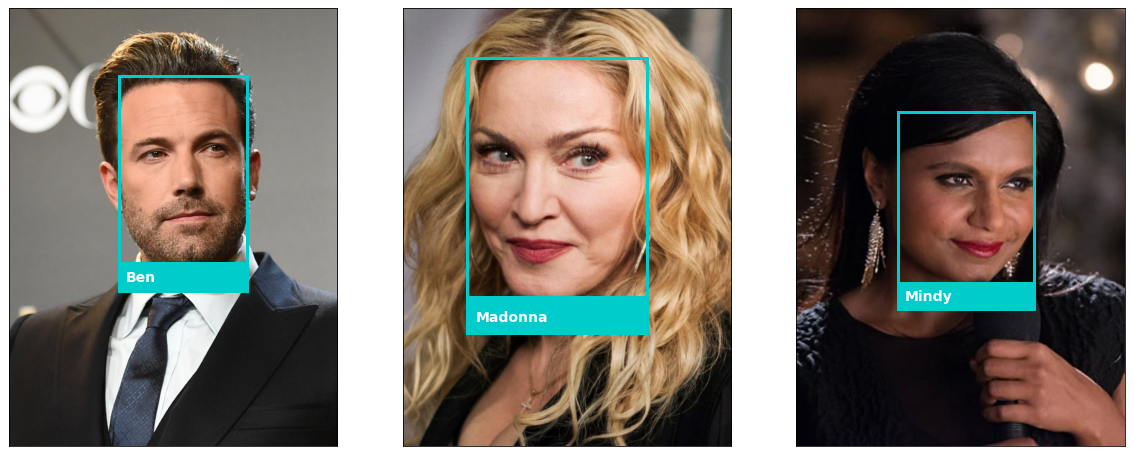
_(Screenshot of the output. Uploaded from local machine)_

# Pseucode

- [x] Preprocess the input image using MTCNN. Return the processed image and the face data.
- [x] Get embeddings using FaceNet.
- [x] In order to make a prediction, pass the image through the model. Choose anchor embedding with the least distance to predicted embedding as the prediction.
- [x] Usde the predicted embdedding's index to get the identity.
- [x] Use the face data to draw bounding box on original image and add identity as text below it.

# Data & Embeddings

In [1]:
import numpy as np

import os
import pickle

import cv2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN
face_detector = MTCNN()

In [3]:
from keras.models import load_model
model = load_model("../input/facenet/facenet_keras.h5")
print(model.inputs, model.outputs, sep='\n')

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [4]:
def pre_process(img):
    face_data = face_detector.detect_faces(img)
    if len(face_data) == 0:
        return
    x,y,w,h = face_data[0]['box']
    face = img[y:y+h, x:x+w]
    resized_face = cv2.resize(face, (160,160))
    normalized_face = (resized_face - resized_face.mean()) / resized_face.std()
    normalized_face = np.expand_dims(normalized_face, axis=0)
    return normalized_face, face_data

In [5]:
def get_embedding(train_dir):
    count = 0
    anchor_embedding = np.zeros(shape=(1,128))
    print(train_dir.split('/')[-1])
    for img_path in os.listdir(train_dir):
        img_path = os.path.join(train_dir, img_path)
        img = plt.imread(img_path)
        if img.shape[-1] > 3:
            continue
        processed_img, _ = pre_process(img)
        anchor_embedding += model.predict(processed_img)
        count += 1
    anchor_embedding = anchor_embedding/count
    
    return anchor_embedding

In [6]:
known_faces = {}
known_embeddings = []
parent_dir = "../input/5-celebrity-faces-dataset/train"
for i, dir_name in enumerate(os.listdir(parent_dir)):
    known_faces[i] = dir_name.replace("_", " ").title()
    known_embeddings.append(get_embedding(os.path.join(parent_dir, dir_name)))

known_embeddings = np.asarray(known_embeddings)
known_embeddings = np.squeeze(known_embeddings, axis=1)

ben_afflek
mindy_kaling
jerry_seinfeld
madonna
elton_john


In [7]:
with open("./known_embeddings.txt", "wb") as fp:
    pickle.dump(known_embeddings, fp)
with open("./known_faces.txt", "wb") as fp:
    pickle.dump(known_faces, fp)

In [8]:
# Once you store the anchor_embeddings to your "local machine", you need not calculate them each time
# However, upload the embeddings before running this cell as they won't be in the notebook's data section

# with open("./known_embeddings.txt", "rb") as fp:
#     known_embeddings = pickle.load(fp)
# with open("./known_faces.txt", "rb") as gp:
#     known_faces = np.asarray(pickle.load(gp))

In [9]:
img1 = plt.imread("../input/5-celebrity-faces-dataset/train/ben_afflek/httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg")
processed_img1, _ = pre_process(img1)
img1_embedding = model.predict(processed_img1)

In [10]:
img2 = plt.imread("../input/5-celebrity-faces-dataset/train/madonna/httpiamediaimdbcomimagesMMVBMTANDQNTAxNDVeQTJeQWpwZBbWUMDIMjQOTYVUXCRALjpg.jpg")
processed_img1, _ = pre_process(img2)
img2_embedding = model.predict(processed_img1)

In [11]:
known_faces[np.argmin(np.apply_along_axis(np.linalg.norm, axis=1, arr=(known_embeddings - img1_embedding)))]

'Ben Afflek'

In [12]:
known_faces[np.argmin(np.apply_along_axis(np.linalg.norm, axis=1, arr=(known_embeddings - img2_embedding)))]

'Madonna'

# Final Function

In [13]:
def plot_image(img, id_code, face_data):
    top_left_x, top_left_y, width, height = face_data[0]['box']
#     plot the bounding box on the input image
#     plt.figure(figsize=(6,6))
    plt.imshow(img)
#     (0, 0.8, 0.8) == aquablue
    plt.gca().add_patch(matplotlib.patches.Rectangle((top_left_x,top_left_y), width, height,
                                                     edgecolor=(0,0.8,0.8), facecolor='none', lw=3))
    plt.gca().add_patch(matplotlib.patches.Rectangle((top_left_x,top_left_y+height), width, 0.15*height,
                                                     edgecolor=(0,0.8,0.8), facecolor=(0,0.8,0.8), lw=3, fill=True))
    plt.text(top_left_x+0.05*width, top_left_y+1.1*height, s=known_faces[id_code].split(' ')[0], color='white', size=14, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    return

In [14]:
def face_recognition(img_path, model, known_faces, known_embeddings):
    img = plt.imread(img_path)
    
    # refusinng RGBA format
    try:
        img.shape[-1] > 3
    except:
        print("Kindly input image with 3 color channels.")
        return
    
    #handling grayscale
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    #preprocessing the image
    processed_img, face_data = pre_process(img)
    top_left_x, top_left_y, width, height = face_data[0]['box']
    
    #getting the embeddings and the identity
    embedding = model.predict(processed_img)
    id_code = np.argmin(np.apply_along_axis(np.linalg.norm, axis=1, arr=(known_embeddings - embedding)))
    
    return img, id_code, face_data

# Testing

In [15]:
import random

val_img_paths = []
val_face_id_codes = []

val_dir = "../input/5-celebrity-faces-dataset/val"
for i, dir_name in enumerate(os.listdir(val_dir)):
    for img_path in os.listdir(os.path.join(val_dir, dir_name)):
        val_img_paths.append(os.path.join(val_dir, dir_name, img_path))
        val_face_id_codes.append(i)
        
#shuffle
temp = list(zip(val_img_paths, val_face_id_codes))
random.shuffle(temp)
val_img_paths, val_face_id_codes = zip(*temp)
val_img_paths, val_face_id_codes = list(val_img_paths), list(val_face_id_codes)

# the above process converts lists to tuples. Later on, we need to subtract, and subtrctrion betweena a tuple and a list is not allowed. Hence, we need to explicity convert the tuple back into a list

In [16]:
#illustrative example of above code

arr0 = ['ab', 'bc', 'cd', 'de']
arr1 = [0, 1, 2, 3]
print(arr0, arr1)

arr2 = list(zip(arr0, arr1))
random.shuffle(arr2)
arr0, arr1 = zip(*arr2)
arr0, arr1 = list(arr0), list(arr1)
print(arr0, arr1)

['ab', 'bc', 'cd', 'de'] [0, 1, 2, 3]
['cd', 'ab', 'bc', 'de'] [2, 0, 1, 3]


In [17]:
predicted_codes = []
for img_path in val_img_paths:
    img, id_code, fd = face_recognition(img_path, model, known_faces, known_embeddings)
    predicted_codes.append(id_code)

In [18]:
predicted_codes

[3, 4, 1, 0, 4, 2, 1, 3, 4, 3, 3, 2, 4, 2, 0, 0, 4, 0, 0, 3, 2, 2, 1, 1, 1]

In [19]:
# we need to use asarray to perform subtraction
np.sum(np.abs(np.asarray(val_face_id_codes) - np.asarray(predicted_codes)))

0

In [20]:
known_faces[predicted_codes[0]], known_faces[val_face_id_codes[0]]

('Madonna', 'Madonna')

In [21]:
from tensorflow.math import confusion_matrix
conf_mat = confusion_matrix(labels=val_face_id_codes, predictions=predicted_codes)

In [22]:
print(conf_mat)

tf.Tensor(
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 5]], shape=(5, 5), dtype=int32)


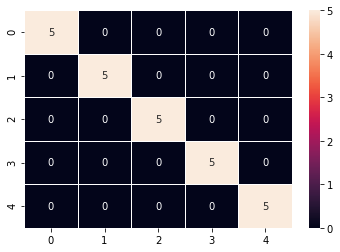

In [23]:
# import seaborn as sns
sns.heatmap(conf_mat, annot=True, linewidth=1, linecolor='w')
plt.show()

# Visualization
#### Added some high-res images for the visualization part.

In [24]:
img_path1 = "../input/additional-data/wp1898881.jpg"
img1, id1, fd1 = face_recognition(img_path1, model, known_faces, known_embeddings)

img_path2 = "../input/additional-data/madonna_43.jpg"
img2, id2, fd2 = face_recognition(img_path2, model, known_faces, known_embeddings)

img_path3 = "../input/additional-data/mindy_mike.jpg"
img3, id3, fd3 = face_recognition(img_path3, model, known_faces, known_embeddings)

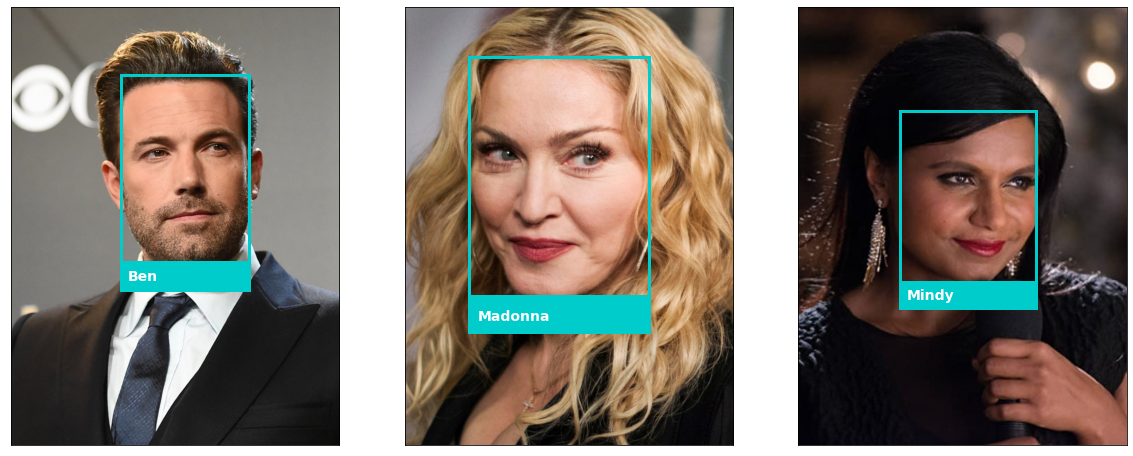

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plot_image(img1, id1, fd1)
plt.subplot(1,3,2)
plot_image(img2, id2, fd2)
plt.subplot(1,3,3)
plot_image(img3, id3, fd3)
plt.show()